In [1]:
import os
import sys

PROJECT_ROOT = r"C:\Users\numpppy\Downloads\TEED" 

if not os.path.exists(PROJECT_ROOT):
    print(f"ERROR: Folder not found: {PROJECT_ROOT}")
    print("\nPlease update PROJECT_ROOT to your TEED folder path")
else:
    print(f"Found TEED folder: {PROJECT_ROOT}")
    
    os.chdir(PROJECT_ROOT)
    sys.path.insert(0, PROJECT_ROOT)
    
    print(f"Working directory: {os.getcwd()}")
    
    print("\nChecking directory structure:")
    required = ['models', 'utils', 'data', 'checkpoints', 'BIPED']
    for d in required:
        exists = "✓" if os.path.exists(d) else "✗"
        print(f"   {exists} {d}/")
    
    print("\nSetup complete!")

Found TEED folder: C:\Users\numpppy\Downloads\TEED
Working directory: C:\Users\numpppy\Downloads\TEED

Checking directory structure:
   ✗ models/
   ✓ utils/
   ✓ data/
   ✓ checkpoints/
   ✓ BIPED/

Setup complete!


In [2]:
import torch

print("="*70)
print("SYSTEM INFO")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = "cuda"
else:
    print("No GPU detected - will use CPU (slow!)")
    device = "cpu"

print(f"\nUsing device: {device}")
print("="*70)

SYSTEM INFO
PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 5060 Ti
GPU memory: 17.1 GB

Using device: cuda


In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.quantization as quantization
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import time
import copy

print("="*70)
print("IMPORTING TEED COMPONENTS")
print("="*70)


try:
    from ted import TED
    print("Exist")
except ImportError as e:
    print(f" (No)TED model: {e}")
    raise

try:
    from utils.AF.Fsmish import smish as Fsmish
    from utils.AF.Xsmish import Smish
    print("Exist")
except ImportError as e:
    print(f" (No) Smish: {e}")
    raise

try:
    from utils.img_processing import count_parameters
    print("Exist")
except ImportError:
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("img_processing missing — fallback enabled")

try:
    from dataset import BipedDataset, TestDataset
    print("BipedDataset & TestDataset loaded")
except ImportError as e:
    print(f"Dataset import error: {e}")
    raise

try:
    from loss2 import bdcn_loss2
    print("Exist")
except ImportError as e:
    print(f" (No) bdcn_loss2: {e}")
    raise


print("\nALL IMPORTS SUCCESSFUL!")

IMPORTING TEED COMPONENTS
Exist
Exist
Exist
BipedDataset & TestDataset loaded
Exist

ALL IMPORTS SUCCESSFUL!


In [4]:
import os
import torch

class QATConfig:

    DATA_ROOT = r"C:\Users\numpppy\Downloads\TEED\BIPED\BIPED\edges"  
    
    CHECKPOINT_DIR = "checkpoints"
    RESULTS_DIR = "results"
    PRETRAINED_PATH = "7_model.pth"   

    IMG_SIZE = 352

    BATCH_SIZE = 8
    NUM_EPOCHS = 10

    LEARNING_RATE_FP32 = 5e-4
    LEARNING_RATE_QAT = 1e-4
    WEIGHT_DECAY = 3e-4

    QAT_START_EPOCH = 4

    LR_MILESTONES = [6, 8]
    LR_GAMMA = 0.1

    OPTIMIZER = 'adamw'
    BETAS = (0.9, 0.999)
    EPS = 1e-8

    LOSS_WEIGHT = 1.1

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    NUM_WORKERS = 0
    PIN_MEMORY = torch.cuda.is_available()

    QAT_BACKEND = 'fbgemm'

    SAVE_EVERY_EPOCH = True


config = QATConfig()

os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(config.RESULTS_DIR, exist_ok=True)

print("="*70)
print("QAT CONFIGURATION")
print("="*70)
print(f"Data Root:       {config.DATA_ROOT}")
print(f"Checkpoint Dir:  {config.CHECKPOINT_DIR}")
print(f"Device:          {config.DEVICE}")
print(f"Batch Size:      {config.BATCH_SIZE}")
print(f"Total Epochs:    {config.NUM_EPOCHS}")
print(f"   FP32 Phase:      Epochs 1-{config.QAT_START_EPOCH-1}")
print(f"   QAT Phase:       Epochs {config.QAT_START_EPOCH}-{config.NUM_EPOCHS}")
print(f"LR (FP32):       {config.LEARNING_RATE_FP32}")
print(f"LR (QAT):        {config.LEARNING_RATE_QAT}")
print(f"Optimizer:       {config.OPTIMIZER.upper()}")
print(f"QAT Backend:     {config.QAT_BACKEND}")
print("="*70)

QAT CONFIGURATION
Data Root:       C:\Users\numpppy\Downloads\TEED\BIPED\BIPED\edges
Checkpoint Dir:  checkpoints
Device:          cuda
Batch Size:      8
Total Epochs:    10
   FP32 Phase:      Epochs 1-3
   QAT Phase:       Epochs 4-10
LR (FP32):       0.0005
LR (QAT):        0.0001
Optimizer:       ADAMW
QAT Backend:     fbgemm


### CELL 5: QAT Model Wrapper (FIXED FOR TEED)

In [5]:
import torch.quantization as quantization


class TEDQuantizable(nn.Module):

    def __init__(self, base_model):
        super(TEDQuantizable, self).__init__()
        
        self.model = base_model
        
        self.quant = quantization.QuantStub()
        self.dequant = quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)

        outputs = self.model(x)

        if isinstance(outputs, list):
            outputs = [self.dequant(out) for out in outputs]
        else:
            outputs = self.dequant(outputs)
        
        return outputs

    def fuse_model(self):
        print("No fusion applied (Smish activation prevents Conv-BN-Act fusion)")
        return


print("TEDQuantizable defined (QAT ready)")

TEDQuantizable defined (QAT ready)


### Helper Functions (FIXED for TEED + QAT)

In [6]:
import torch.quantization as quantization

def prepare_qat_model(model, config):

    print("\n" + "="*70)
    print("PREPARING QAT MODEL")
    print("="*70)

    model_qat = TEDQuantizable(model)
    model_qat.qconfig = quantization.get_default_qat_qconfig(config.QAT_BACKEND)

    # Optional fusion (not used, TEED uses Smish)
    model_qat.fuse_model()

    # Insert FakeQuant + observers
    quantization.prepare_qat(model_qat, inplace=True)

    print("FakeQuant & Observers inserted")
    print("Model ready for QAT!")
    return model_qat

def load_pretrained(model, path, device='cpu'):

    print(f"\nLoading pretrained weights: {path}")

    if not os.path.exists(path):
        raise FileNotFoundError(f"Not found: {path}")

    checkpoint = torch.load(path, map_location=device)

    if isinstance(checkpoint, dict):
        if "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"], strict=False)
            print(f" Loaded epoch: {checkpoint.get('epoch', 'unknown')}")
        elif "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"], strict=False)
            print("Loaded state_dict")
        else:
            model.load_state_dict(checkpoint, strict=False)
            print("Loaded raw dict")
    else:
        model.load_state_dict(checkpoint, strict=False)
        print("Loaded raw tensor weights")

    print("Pretrained weights loaded!")
    return model

def convert_to_quantized(model_qat):
    
    print("\n" + "="*70)
    print("CONVERTING MODEL TO INT8 (POST-QAT)")
    print("="*70)

    model_qat.eval()
    model_int8 = quantization.convert(model_qat, inplace=False)

    print("✓ Conversion complete!")
    print("✓ Model is now REAL INT8!")
    return model_int8

print("Helper functions defined (QAT Ready)")

Helper functions defined (QAT Ready)


### CELL 7: Training & Validation

In [7]:
def train_one_epoch(model, train_loader, optimizer, device, epoch, config, is_qat):
    
    model.train()
    total_loss = 0
    losses = []

    phase = "QAT" if is_qat else "FP32"
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{config.NUM_EPOCHS} [{phase}]')

    for batch in pbar:
        # batch is a dict: {"images": ..., "labels": ...}
        images = batch["images"].to(device)
        edges = batch["labels"].to(device)

        # Forward pass
        outputs = model(images)   # list: [y1, y2, y3, y_fuse]

        # Multi-scale weighted loss
        weights = [0.5, 0.7, 0.9, 1.0]
        loss = sum(
            w * bdcn_loss2(pred, edges, config.LOSS_WEIGHT)
            for w, pred in zip(weights, outputs)
        ) / sum(weights)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1.0
        )

        optimizer.step()

        loss_val = loss.item()
        losses.append(loss_val)

        avg = np.mean(losses[-20:]) if len(losses) > 20 else np.mean(losses)

        pbar.set_postfix({
            "loss": f"{loss_val:.4f}",
            "avg": f"{avg:.4f}"
        })

        total_loss += loss_val

    epoch_loss = total_loss / len(train_loader)
    return epoch_loss

def validate(model, val_loader, device, config):
    
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            images = batch["images"].to(device)
            edges = batch["labels"].to(device)

            outputs = model(images)

            # Use final fused output (last in list)
            loss = bdcn_loss2(outputs[-1], edges, config.LOSS_WEIGHT)
            total_loss += loss.item()

    return total_loss / len(val_loader)

print("Training functions defined (QAT + TEED compatible)")

Training functions defined (QAT + TEED compatible)


### CELL 8: Load Dataset (FIXED - ImageNet Normalization)

In [8]:
print("="*70)
print("LOADING DATASET (FIXED PREPROCESSING)")
print("="*70)

device = torch.device(config.DEVICE)
print(f"Device: {device}\n")

class Args:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

# Train args (dummy mean - not used anymore)
train_args = Args(
    train_list="train_pair0.lst",
    train_data="biped",
    mean_train=[0, 0, 0]  # Dummy, won't be used
)

# Test args (dummy mean - not used anymore)
test_args = Args(
    mean_test=[0, 0, 0],  # Dummy, won't be used
    up_scale=False
)

print("Loading training dataset...")
train_dataset = BipedDataset(
    data_root=config.DATA_ROOT,
    img_height=config.IMG_SIZE,
    img_width=config.IMG_SIZE,
    train_mode='train',
    dataset_type='rgbr',
    crop_img=False,
    arg=train_args
)

print("Loading test dataset...")
test_dataset = TestDataset(
    data_root=config.DATA_ROOT,
    test_data="BIPED",
    img_height=config.IMG_SIZE,
    img_width=config.IMG_SIZE,
    test_list="test_pair.lst",
    arg=test_args
)

print(f"\n✓ Train samples: {len(train_dataset)}")
print(f"✓ Test samples:  {len(test_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,      
    pin_memory=False   
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Test batches:  {len(test_loader)}")

print("\n" + "="*70)
print("VERIFYING PREPROCESSING (CRITICAL!)")
print("="*70)

sample_batch = train_dataset[0]
sample_img = sample_batch['images']
sample_gt = sample_batch['labels']

print(f"\nSample Image Tensor:")
print(f"   Shape:  {sample_img.shape}")
print(f"   Dtype:  {sample_img.dtype}")
print(f"   Min:    {sample_img.min():.4f}")
print(f"   Max:    {sample_img.max():.4f}")
print(f"   Mean:   {sample_img.mean():.4f}")
print(f"   Std:    {sample_img.std():.4f}")

expected_min = -3.0
expected_max = 3.0

print(f"\n🔍 Analysis:")
if sample_img.min() > expected_min and sample_img.max() < expected_max:
    if abs(sample_img.mean()) < 0.5:  # Should be close to 0
        print("PREPROCESSING CORRECT!")
        print("   ✓ Range matches ImageNet normalization")
        print("   ✓ Mean is close to 0")
        print("   ✓ Ready for training!")
    else:
        print("WARNING: Mean is not close to 0")
        print(f"   Got mean: {sample_img.mean():.4f}")
else:
    print("PREPROCESSING WRONG!")
    print(f"   Expected range: [{expected_min}, {expected_max}]")
    print(f"   Got range: [{sample_img.min():.2f}, {sample_img.max():.2f}]")
    print("\nSTOP! Check if you saved the fixed dataset.py!")
    raise ValueError("Preprocessing mismatch! Fix dataset.py first!")

print("\n Dataset ready for QAT training!")

LOADING DATASET (FIXED PREPROCESSING)
Device: cuda

Loading training dataset...
Loading test dataset...

✓ Train samples: 200
✓ Test samples:  50
✓ Train batches: 25
✓ Test batches:  50

VERIFYING PREPROCESSING (CRITICAL!)

Sample Image Tensor:
   Shape:  torch.Size([3, 352, 352])
   Dtype:  torch.float32
   Min:    -2.1179
   Max:    2.6400
   Mean:   0.3897
   Std:    1.2453

🔍 Analysis:
PREPROCESSING CORRECT!
   ✓ Range matches ImageNet normalization
   ✓ Mean is close to 0
   ✓ Ready for training!

 Dataset ready for QAT training!


### CELL 9: Create Model (FIXED)

In [9]:
print("="*70)
print("CREATING TEED MODEL")
print("="*70)

model = TED()
print("TEED model created")

total_params = count_parameters(model)
print(f"Parameters: {total_params:,} (~{total_params//1000}K)")

if os.path.exists(config.PRETRAINED_PATH):
    print(f"Found pretrained model: {config.PRETRAINED_PATH}")
    model = load_pretrained(model, config.PRETRAINED_PATH, device=config.DEVICE)
    mode = "FINE-TUNING"
else:
    print(f"Pretrained model not found: {config.PRETRAINED_PATH}")
    mode = "TRAIN FROM SCRATCH"


print(f"\nMode Selected: {mode}")

model = model.to(config.DEVICE)
print(f"Model moved to device: {config.DEVICE}")

CREATING TEED MODEL
TEED model created
Parameters: 58,910 (~58K)
Found pretrained model: 7_model.pth

Loading pretrained weights: 7_model.pth
Loaded raw dict
Pretrained weights loaded!

Mode Selected: FINE-TUNING
Model moved to device: cuda


### CELL 10: Optimizer & Scheduler (FIXED for FP32 + QAT training)

In [10]:
print("="*70)
print("OPTIMIZER SETUP")
print("="*70)

optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE_FP32,
    betas=config.BETAS,
    eps=config.EPS,
    weight_decay=config.WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=config.LR_MILESTONES,
    gamma=config.LR_GAMMA
)

print(f"Initial FP32 LR: {config.LEARNING_RATE_FP32}")
print(f"QAT LR will switch to: {config.LEARNING_RATE_QAT} at epoch {config.QAT_START_EPOCH}")
print(f"LR Milestones: {config.LR_MILESTONES}")

OPTIMIZER SETUP
Initial FP32 LR: 0.0005
QAT LR will switch to: 0.0001 at epoch 4
LR Milestones: [6, 8]


### CELL 11: MAIN TRAINING LOOP (FIXED FOR TEED + QAT)

In [12]:
print("\n" + "="*70)
print("STARTING QAT TRAINING")
print("="*70)
print(f"\nPhase 1 (FP32): Epochs 1-{config.QAT_START_EPOCH-1}")
print(f"Phase 2 (QAT):  Epochs {config.QAT_START_EPOCH}-{config.NUM_EPOCHS}")
print("="*70 + "\n")

best_loss = float('inf')
history = {'train_loss': [], 'val_loss': [], 'lr': [], 'phase': []}
qat_prepared = False

for epoch in range(1, config.NUM_EPOCHS + 1):
    epoch_start = time.time()

    print(f"\n{'='*70}")
    print(f"EPOCH {epoch}/{config.NUM_EPOCHS}")
    print(f"{'='*70}")

    # -----------------------------------------------------
    # SWITCH TO QAT MODE
    # -----------------------------------------------------
    if epoch == config.QAT_START_EPOCH and not qat_prepared:
        print("\n" + "🔄 "*30)
        print("SWITCHING TO QAT MODE")
        print("🔄 "*30)

        # Convert FP32 TEED → QAT-ready wrapper
        model = prepare_qat_model(model, config)
        model = model.to(config.DEVICE)

        # RESET optimizer for QAT (IMPORTANT!)
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config.LEARNING_RATE_QAT,
            betas=config.BETAS,
            eps=config.EPS,
            weight_decay=config.WEIGHT_DECAY
        )

        print(f"\n✓ LR changed: {config.LEARNING_RATE_FP32} → {config.LEARNING_RATE_QAT}\n")
        qat_prepared = True

    # ---------------------
    # TRAIN ONE EPOCH
    # ---------------------
    is_qat = epoch >= config.QAT_START_EPOCH

    train_loss = train_one_epoch(
        model, train_loader, optimizer,
        config.DEVICE, epoch, config, is_qat
    )

    # ---------------------
    # VALIDATE
    # ---------------------
    val_loss = validate(model, test_loader, config.DEVICE, config)

    # ---------------------
    # STEP SCHEDULER (FP32 ONLY)
    # ---------------------
    if not is_qat:
        scheduler.step()

    lr = optimizer.param_groups[0]['lr']

    # ---------------------
    # LOG HISTORY
    # ---------------------
    phase = "QAT" if is_qat else "FP32"
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(lr)
    history['phase'].append(phase)

    # ---------------------
    # SUMMARY PRINT
    # ---------------------
    epoch_time = time.time() - epoch_start
    print(f"\n[{phase}] Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {lr:.6f} | Time: {epoch_time:.1f}s")

    # ----------------------------------------------------
    # SAVE BEST MODEL OR EVERY EPOCH
    # ----------------------------------------------------
    is_best = val_loss < best_loss
    if is_best:
        best_loss = val_loss

    if config.SAVE_EVERY_EPOCH or is_best:
        ckpt_path = os.path.join(config.CHECKPOINT_DIR, f"epoch{epoch}_qat.pth")
        
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_loss,
            "is_qat": is_qat
        }, ckpt_path)

        if is_best:
            print(f"✓ NEW BEST MODEL SAVED → {ckpt_path}")


# ----------------------------------------------------
# DONE
# ----------------------------------------------------
print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"Best validation loss: {best_loss:.4f}")


STARTING QAT TRAINING

Phase 1 (FP32): Epochs 1-3
Phase 2 (QAT):  Epochs 4-10


EPOCH 1/10


Epoch 1/10 [FP32]: 100%|██████████| 25/25 [00:03<00:00,  6.37it/s, loss=0.3020, avg=0.3277]
                                                           


[FP32] Train: 0.3432 | Val: 0.0464 | LR: 0.000500 | Time: 6.5s
✓ NEW BEST MODEL SAVED → checkpoints\epoch1_qat.pth

EPOCH 2/10


Epoch 2/10 [FP32]: 100%|██████████| 25/25 [00:02<00:00,  8.56it/s, loss=0.2127, avg=0.3065]
                                                           


[FP32] Train: 0.3041 | Val: 0.0432 | LR: 0.000500 | Time: 5.4s
✓ NEW BEST MODEL SAVED → checkpoints\epoch2_qat.pth

EPOCH 3/10


Epoch 3/10 [FP32]: 100%|██████████| 25/25 [00:02<00:00,  8.62it/s, loss=0.2264, avg=0.3074]
C:\Users\numpppy\AppData\Local\Temp\ipykernel_28688\139390145.py:16: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantization.prepare_qat(model_qat, inplace=True)
C:\Users\numpppy\anaconda3\envs\jkl\lib\site-packages\torch\ao\quantization\observer.py:246: UserWarning: Please use


[FP32] Train: 0.2944 | Val: 0.0418 | LR: 0.000500 | Time: 5.4s
✓ NEW BEST MODEL SAVED → checkpoints\epoch3_qat.pth

EPOCH 4/10

🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 
SWITCHING TO QAT MODE
🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 🔄 

PREPARING QAT MODEL
No fusion applied (Smish activation prevents Conv-BN-Act fusion)
FakeQuant & Observers inserted
Model ready for QAT!

✓ LR changed: 0.0005 → 0.0001



Epoch 4/10 [QAT]: 100%|██████████| 25/25 [00:03<00:00,  8.09it/s, loss=0.2768, avg=0.2570]
                                                           


[QAT] Train: 0.2546 | Val: 0.0418 | LR: 0.000100 | Time: 5.8s
✓ NEW BEST MODEL SAVED → checkpoints\epoch4_qat.pth

EPOCH 5/10


Epoch 5/10 [QAT]: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s, loss=0.2587, avg=0.2777]
                                                           


[QAT] Train: 0.2734 | Val: 0.0416 | LR: 0.000100 | Time: 5.7s
✓ NEW BEST MODEL SAVED → checkpoints\epoch5_qat.pth

EPOCH 6/10


Epoch 6/10 [QAT]: 100%|██████████| 25/25 [00:03<00:00,  8.10it/s, loss=0.3427, avg=0.2873]
                                                           


[QAT] Train: 0.2864 | Val: 0.0414 | LR: 0.000100 | Time: 5.8s
✓ NEW BEST MODEL SAVED → checkpoints\epoch6_qat.pth

EPOCH 7/10


Epoch 7/10 [QAT]: 100%|██████████| 25/25 [00:03<00:00,  8.20it/s, loss=0.2594, avg=0.2872]
                                                           


[QAT] Train: 0.2847 | Val: 0.0411 | LR: 0.000100 | Time: 5.7s
✓ NEW BEST MODEL SAVED → checkpoints\epoch7_qat.pth

EPOCH 8/10


Epoch 8/10 [QAT]: 100%|██████████| 25/25 [00:03<00:00,  8.10it/s, loss=0.3019, avg=0.2534]
                                                           


[QAT] Train: 0.2614 | Val: 0.0411 | LR: 0.000100 | Time: 5.8s
✓ NEW BEST MODEL SAVED → checkpoints\epoch8_qat.pth

EPOCH 9/10


Epoch 9/10 [QAT]: 100%|██████████| 25/25 [00:03<00:00,  8.13it/s, loss=0.3277, avg=0.2951]
                                                           


[QAT] Train: 0.2892 | Val: 0.0410 | LR: 0.000100 | Time: 5.8s
✓ NEW BEST MODEL SAVED → checkpoints\epoch9_qat.pth

EPOCH 10/10


Epoch 10/10 [QAT]: 100%|██████████| 25/25 [00:03<00:00,  8.16it/s, loss=0.2563, avg=0.2712]
                                                           


[QAT] Train: 0.2648 | Val: 0.0410 | LR: 0.000100 | Time: 5.7s

TRAINING COMPLETE!
Best validation loss: 0.0410


### CELL 12: Convert to INT8 (FIXED - Dynamic Quantization)

In [13]:
if qat_prepared:
    print("\n" + "="*70)
    print("CONVERTING TO INT8 (DYNAMIC QUANTIZATION)")
    print("="*70)
    
    model.eval()
    
    if isinstance(model, TEDQuantizable):
        base_model = model.model
        print("✓ Extracted base model from QAT wrapper")
    else:
        base_model = model
    
    # ============================================
    # Apply Dynamic Quantization (Works with Smish!)
    # ============================================
    print("\n Applying dynamic quantization...")
    
    model_int8 = torch.quantization.quantize_dynamic(
        base_model,
        {torch.nn.Conv2d, torch.nn.ConvTranspose2d},
        dtype=torch.qint8
    )
    
    print("Dynamic quantization complete.")
    
    # Save INT8 model
    int8_path = os.path.join(config.CHECKPOINT_DIR, 'teed_qat_int8_REVISED.pth')
    
    torch.save({
        'model_state_dict': model_int8.state_dict(),
        'quantized': True,
        'method': 'QAT_dynamic',  # Changed!
        'backend': config.QAT_BACKEND,
        'preprocessing': 'ImageNet_normalized',
        'best_val_loss': best_loss,
        'trained_epochs': config.NUM_EPOCHS
    }, int8_path)
    
    print(f"INT8 model saved: {int8_path}")
    
    # ============================================
    # Size Comparison
    # ============================================
    print("\nComputing model sizes...")
    
    # Save FP32 temporarily
    torch.save(base_model.state_dict(), 'temp_fp32NEW.pth')
    size_fp32 = os.path.getsize('temp_fp32NEW.pth') / (1024*1024)
    os.remove('temp_fp32NEW.pth')
    
    # INT8 size
    size_int8 = os.path.getsize(int8_path) / (1024*1024)
    
    print(f"\nModel Size Comparison:")
    print(f"   FP32:  {size_fp32:.2f} MB")
    print(f"   INT8:  {size_int8:.2f} MB")
    print(f"   Reduction: {(1-size_int8/size_fp32)*100:.1f}%")
    print(f"   Compression: {size_fp32/size_int8:.2f}×")
    
    print("\n" + "="*70)
    print("QAT TRAINING & CONVERSION COMPLETE!")
    print("="*70)
    print(f"Best validation loss: {best_loss:.4f}")
    print(f"INT8 model ready: {int8_path}")
    print(f"Model size: {size_int8:.2f} MB ({size_fp32/size_int8:.1f}× smaller)")
    
    print("\nNote: Used dynamic quantization (compatible with Smish)")
    print("   Model trained with QAT, deployed with dynamic quantization")
    
else:
    print("\nQAT not prepared yet!")
    print("   Make sure training reached QAT phase (epoch 4+)")


CONVERTING TO INT8 (DYNAMIC QUANTIZATION)
✓ Extracted base model from QAT wrapper

 Applying dynamic quantization...
Dynamic quantization complete.
INT8 model saved: checkpoints\teed_qat_int8_REVISED.pth

Computing model sizes...

Model Size Comparison:
   FP32:  0.32 MB
   INT8:  0.26 MB
   Reduction: 19.1%
   Compression: 1.24×

QAT TRAINING & CONVERSION COMPLETE!
Best validation loss: 0.0410
INT8 model ready: checkpoints\teed_qat_int8_REVISED.pth
Model size: 0.26 MB (1.2× smaller)

Note: Used dynamic quantization (compatible with Smish)
   Model trained with QAT, deployed with dynamic quantization


C:\Users\numpppy\AppData\Local\Temp\ipykernel_28688\2794249305.py:19: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = torch.quantization.quantize_dynamic(


### TESTING UDED

COMPARISON: ORIGINAL TEED vs QAT TEED (NO SIZE COMPARISON)

Loading Original TEED...
   ✓ Original TEED loaded

Loading QAT TEED...
   ✓ QAT TEED loaded

Loading test image...
   Loaded: C:\Users\numpppy\Downloads\TEED\UDED-main\imgs\16-tire.png

Preprocessing images...
   ✓ Preprocessing complete

Running inference...
   ✓ Inference complete

STATISTICS COMPARISON

Original TEED:
   Min:  0.4378
   Max:  0.9968
   Mean: 0.4784
   Std:  0.1206

QAT TEED:
   Min:  0.4378
   Max:  0.9656
   Mean: 0.4951
   Std:  0.1155

Difference (|Original - QAT|):
   Mean: 0.0505
   Max:  0.5516
   Min:  0.0000

Creating visualization...


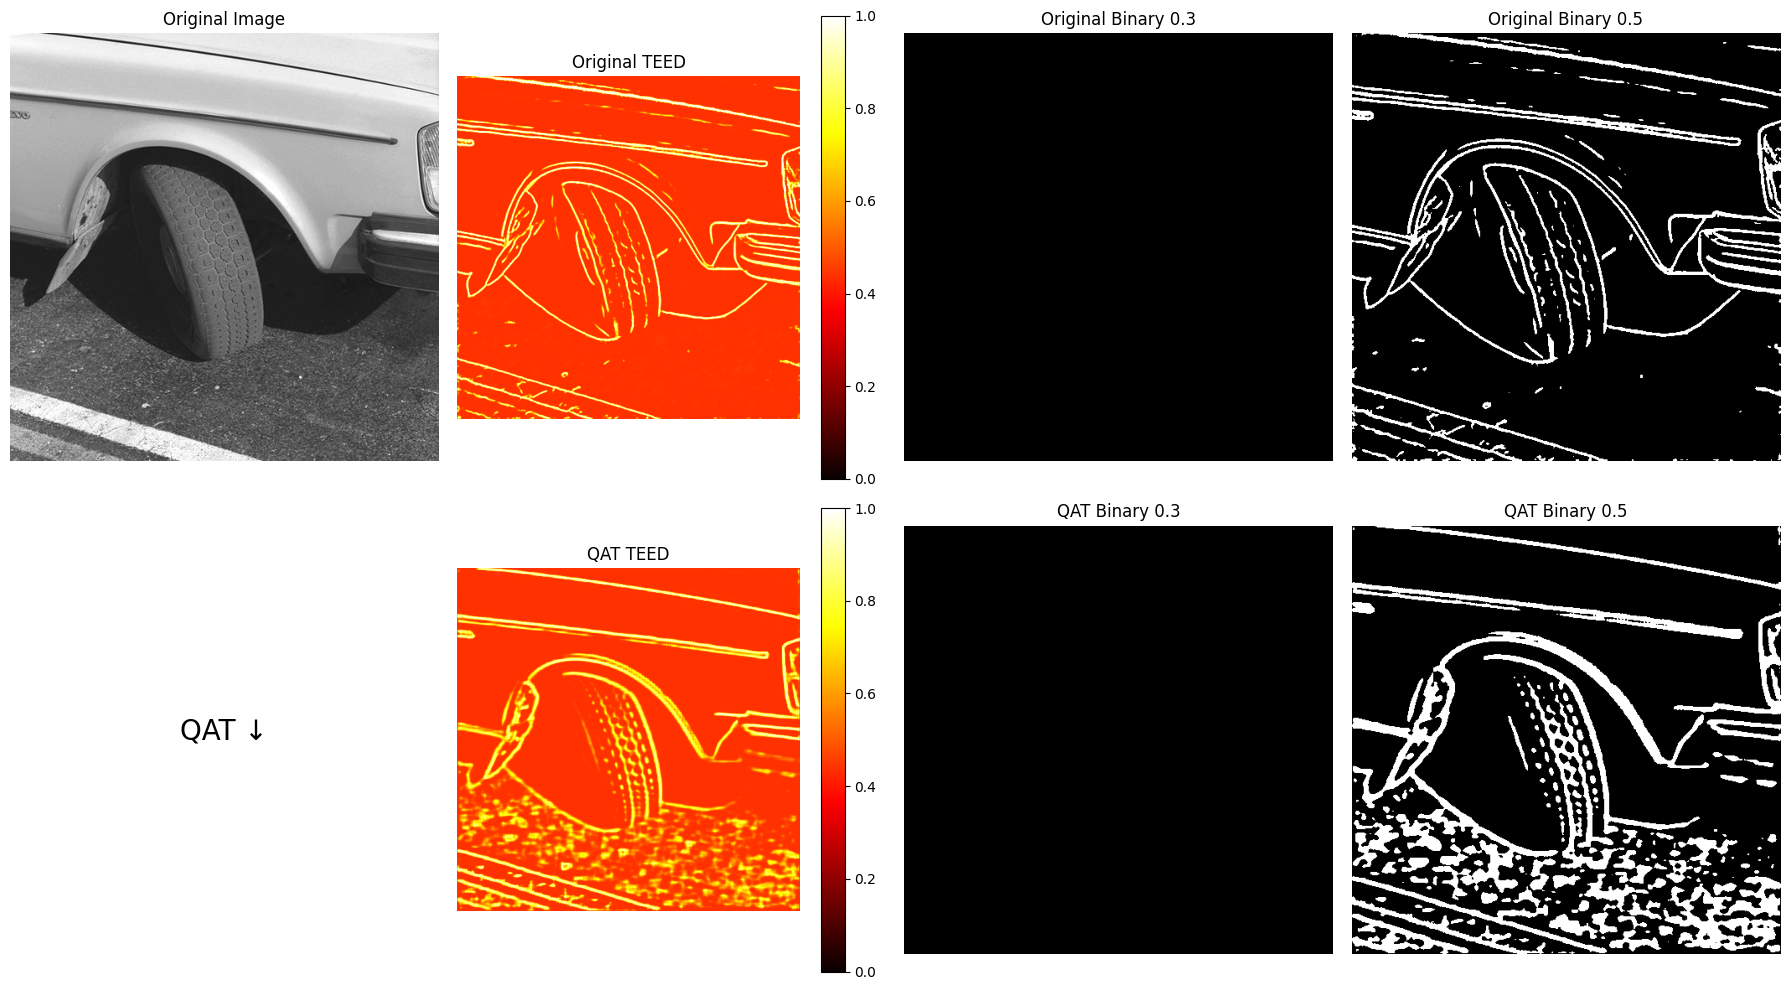


SUMMARY

Edge mean difference: 0.050520677
Max difference: 0.5516175

✓ Result: EXCELLENT similarity between Original vs QAT



In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ted import TED

print("="*70)
print("COMPARISON: ORIGINAL TEED vs QAT TEED (NO SIZE COMPARISON)")
print("="*70)

# ============================================
# 1. Load Original TEED
# ============================================
print("\nLoading Original TEED...")

model_original = TED()
ckpt_original = torch.load("7_model.pth", map_location="cpu")

if isinstance(ckpt_original, dict) and 'model_state_dict' in ckpt_original:
    model_original.load_state_dict(ckpt_original['model_state_dict'])
else:
    model_original.load_state_dict(ckpt_original)

model_original.eval()
print("   ✓ Original TEED loaded")

# ============================================
# 2. Load QAT TEED
# ============================================
print("\nLoading QAT TEED...")

model_qat = TED()
ckpt_qat = torch.load("checkpoints/teed_qat_int8_REVISED.pth", map_location="cpu")

# Clean state dict from QAT observers/fake quant
clean_state = {k: v for k, v in ckpt_qat["model_state_dict"].items()
               if "fake_quant" not in k and "observer" not in k}

model_qat.load_state_dict(clean_state, strict=False)
model_qat.eval()
print("   ✓ QAT TEED loaded")

# ============================================
# 3. Load test image
# ============================================
print("\nLoading test image...")

img_path = r"C:\Users\numpppy\Downloads\TEED\UDED-main\imgs\16-tire.png"
img = cv2.imread(img_path)
orig = img.copy()

print(f"   Loaded: {img_path}")

# ============================================
# 4. Preprocess inputs
# ============================================

print("\nPreprocessing images...")

# For Original TEED (BGR - mean)
img_original = img.copy().astype(np.float32)
img_original -= np.array([103.939, 116.779, 123.68])
img_original = torch.from_numpy(img_original.transpose(2,0,1)).unsqueeze(0).float()

# For QAT TEED (ImageNet normalized)
img_qat = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img_qat = img_qat.astype(np.float32) / 255.0
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])
img_qat = (img_qat - mean) / std
img_qat = torch.from_numpy(img_qat.transpose(2,0,1)).unsqueeze(0).float()

print("   ✓ Preprocessing complete")

# ============================================
# 5. Run inference
# ============================================
print("\nRunning inference...")

with torch.no_grad():
    out_ori = model_original(img_original)
    edge_original = torch.sigmoid(out_ori[-1])[0, 0].numpy()

    out_qat = model_qat(img_qat)
    edge_qat = torch.sigmoid(out_qat[-1])[0, 0].numpy()

print("   ✓ Inference complete")

# ============================================
# 6. Statistics
# ============================================
print("\n" + "="*70)
print("STATISTICS COMPARISON")
print("="*70)

print("\nOriginal TEED:")
print(f"   Min:  {edge_original.min():.4f}")
print(f"   Max:  {edge_original.max():.4f}")
print(f"   Mean: {edge_original.mean():.4f}")
print(f"   Std:  {edge_original.std():.4f}")

print("\nQAT TEED:")
print(f"   Min:  {edge_qat.min():.4f}")
print(f"   Max:  {edge_qat.max():.4f}")
print(f"   Mean: {edge_qat.mean():.4f}")
print(f"   Std:  {edge_qat.std():.4f}")

# Differences
diff = np.abs(edge_original - edge_qat)

print("\nDifference (|Original - QAT|):")
print(f"   Mean: {diff.mean():.4f}")
print(f"   Max:  {diff.max():.4f}")
print(f"   Min:  {diff.min():.4f}")

# ============================================
# 7. Visualization
# ============================================

print("\nCreating visualization...")

fig = plt.figure(figsize=(18, 10))

# Row 1
plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(2,4,2)
plt.imshow(edge_original, cmap="hot", vmin=0, vmax=1)
plt.title("Original TEED")
plt.colorbar()
plt.axis("off")

plt.subplot(2,4,3)
plt.imshow((edge_original>0.3).astype(np.float32), cmap="gray")
plt.title("Original Binary 0.3")
plt.axis("off")

plt.subplot(2,4,4)
plt.imshow((edge_original>0.5).astype(np.float32), cmap="gray")
plt.title("Original Binary 0.5")
plt.axis("off")

# Row 2
plt.subplot(2,4,5)
plt.text(0.5,0.5,"QAT ↓", fontsize=20, ha="center")
plt.axis("off")

plt.subplot(2,4,6)
plt.imshow(edge_qat, cmap="hot", vmin=0, vmax=1)
plt.title("QAT TEED")
plt.colorbar()
plt.axis("off")

plt.subplot(2,4,7)
plt.imshow((edge_qat>0.3).astype(np.float32), cmap="gray")
plt.title("QAT Binary 0.3")
plt.axis("off")

plt.subplot(2,4,8)
plt.imshow((edge_qat>0.5).astype(np.float32), cmap="gray")
plt.title("QAT Binary 0.5")
plt.axis("off")

plt.tight_layout()
plt.show()

# ============================================
# 8. Summary
# ============================================
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print("\nEdge mean difference:", diff.mean())
print("Max difference:", diff.max())

if diff.mean() < 0.1:
    print("\n✓ Result: EXCELLENT similarity between Original vs QAT")
else:
    print("\n⚠️  Noticeable difference detected")

print("\n" + "="*70)

In [22]:
import torch
import cv2
import numpy as np
from ted import TED
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


# ============================================
# 1. Load Both Models
# ============================================
print("\nLoading models...")

# Original TEED
model_original = TED()
ckpt_original = torch.load('7_model.pth', map_location='cpu')
if isinstance(ckpt_original, dict) and 'model_state_dict' in ckpt_original:
    model_original.load_state_dict(ckpt_original['model_state_dict'])
else:
    model_original.load_state_dict(ckpt_original)
model_original.eval()

# QAT TEED
model_qat = TED()
ckpt_qat = torch.load('checkpoints/teed_qat_int8_FIXED.pth', map_location='cpu')
clean_state = {k: v for k, v in ckpt_qat['model_state_dict'].items() 
               if 'fake_quant' not in k and 'observer' not in k}
model_qat.load_state_dict(clean_state, strict=False)
model_qat.eval()

print(" Models loaded")

# ============================================
# 2. Load Test Image
# ============================================
img_path = r"C:\Users\numpppy\Downloads\TEED\UDED-main\imgs\16-tire.png"
img = cv2.imread(img_path)

# Preprocess for Original (BGR mean)
img_original = img.copy().astype(np.float32)
img_original -= np.array([103.939, 116.779, 123.68])
img_original = img_original.transpose(2, 0, 1)
img_original = torch.from_numpy(img_original).unsqueeze(0).float()

# Preprocess for QAT (ImageNet)
img_qat = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img_qat = img_qat.astype(np.float32) / 255.0
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_qat = (img_qat - mean) / std
img_qat = torch.from_numpy(img_qat.transpose(2, 0, 1)).unsqueeze(0).float()

print("   ✓ Image preprocessed")

# ============================================
# 3. Inference
# ============================================
print("\nRunning inference...")

with torch.no_grad():
    # Original
    outputs_original = model_original(img_original)
    edge_original = torch.sigmoid(outputs_original[-1])[0, 0].numpy()
    
    # QAT
    outputs_qat = model_qat(img_qat)
    edge_qat = torch.sigmoid(outputs_qat[-1])[0, 0].numpy()

print("   ✓ Inference complete")

# ============================================
# 4. Calculate Metrics
# ============================================
print("\n3️⃣  Calculating metrics...")

# MAE (Mean Absolute Error)
mae = np.mean(np.abs(edge_original - edge_qat))

# MSE (Mean Squared Error)
mse = np.mean((edge_original - edge_qat) ** 2)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# PSNR (Peak Signal-to-Noise Ratio)
# For normalized images [0, 1], data_range = 1.0
psnr_value = psnr(edge_original, edge_qat, data_range=1.0)

# SSIM (Structural Similarity Index)
ssim_value = ssim(edge_original, edge_qat, data_range=1.0)

# Correlation Coefficient
correlation = np.corrcoef(edge_original.flatten(), edge_qat.flatten())[0, 1]

# Max/Min differences
max_diff = np.max(np.abs(edge_original - edge_qat))
min_diff = np.min(np.abs(edge_original - edge_qat))

# Percentage of pixels with diff > threshold
threshold_5 = np.mean(np.abs(edge_original - edge_qat) > 0.05) * 100
threshold_10 = np.mean(np.abs(edge_original - edge_qat) > 0.10) * 100

# ============================================
# 5. Display Results
# ============================================
print("\n" + "="*70)
print("DETAILED METRICS RESULTS")
print("="*70)

print("\n📊 Error Metrics:")
print(f"   MAE (Mean Absolute Error):     {mae:.6f}")
print(f"   MSE (Mean Squared Error):      {mse:.6f}")
print(f"   RMSE (Root Mean Squared Error): {rmse:.6f}")

print("\n📊 Similarity Metrics:")
print(f"   SSIM (Structural Similarity):   {ssim_value:.6f}")
print(f"   PSNR (Peak Signal-to-Noise):    {psnr_value:.2f} dB")
print(f"   Correlation Coefficient:        {correlation:.6f}")

print("\n📊 Difference Statistics:")
print(f"   Min Difference:                 {min_diff:.6f}")
print(f"   Max Difference:                 {max_diff:.6f}")
print(f"   Mean Difference:                {mae:.6f}")

print("\n📊 Pixel-wise Analysis:")
print(f"   Pixels with diff > 0.05:        {threshold_5:.2f}%")
print(f"   Pixels with diff > 0.10:        {threshold_10:.2f}%")
print(f"   Pixels with diff ≤ 0.05:        {100-threshold_5:.2f}%")


# ============================================
# Summary Table
# ============================================
print("\n" + "="*70)
print("METRICS SUMMARY TABLE")
print("="*70)

print(f"\n{'Metric':<30} {'Value':<15}")
print("-"*70)
print(f"{'MAE (Mean Absolute Error)':<30} {mae:.6f}{'':>8}")
print(f"{'MSE (Mean Squared Error)':<30} {mse:.6f}{'':>8}")
print(f"{'RMSE (Root MSE)':<30} {rmse:.6f}{'':>8}")
print(f"{'SSIM (Structural Similarity)':<30} {ssim_value:.6f}{'':>8}")
print(f"{'PSNR (Peak SNR)':<30} {psnr_value:.2f} dB{'':>6}")
print(f"{'Correlation Coefficient':<30} {correlation:.6f}{'':>8}")




1️⃣  Loading models...
 Models loaded
   ✓ Image preprocessed

2️⃣  Running inference...
   ✓ Inference complete

3️⃣  Calculating metrics...

DETAILED METRICS RESULTS

📊 Error Metrics:
   MAE (Mean Absolute Error):     0.048402
   MSE (Mean Squared Error):      0.011526
   RMSE (Root Mean Squared Error): 0.107358

📊 Similarity Metrics:
   SSIM (Structural Similarity):   0.683058
   PSNR (Peak Signal-to-Noise):    19.38 dB
   Correlation Coefficient:        0.590259

📊 Difference Statistics:
   Min Difference:                 0.000000
   Max Difference:                 0.552011
   Mean Difference:                0.048402

📊 Pixel-wise Analysis:
   Pixels with diff > 0.05:        23.62%
   Pixels with diff > 0.10:        16.93%
   Pixels with diff ≤ 0.05:        76.38%

METRICS SUMMARY TABLE

Metric                         Value          
----------------------------------------------------------------------
MAE (Mean Absolute Error)      0.048402        
MSE (Mean Squared Error)      